In [1]:
import pandas as pd
import numpy as np
from config.emo_utils import *
import config.config as cfg

X_train, y_train = read_csv(cfg.train_path) 
X_test, y_test = read_csv(cfg.test_path)

In [2]:
X_train[:5]

array(['never talk to me again', 'I am proud of your achievements',
       'It is the worst day in my life', 'Miss you so much',
       'food is life'], dtype='<U52')

In [3]:
for idx in np.random.choice(range(len(X_train)), 5):
    print(X_train[idx], label_to_emoji(y_train[idx]))

How dare you ask that 😞
I am at the baseball game ⚾
this guy was such a joke 😄
he is so cute ❤️
I cooked meat 🍴


In [4]:
index_to_words, words_to_index, words_to_vec_map = read_glove_vecs(cfg.glove_path)

word = "chair"
idx = 55555
print(f"The index of word:{word} in the vocabulary is {words_to_index[word]}")
print(f"The {idx}th word in the vocabulary is {index_to_words[idx]}")

The index of word:chair in the vocabulary is 96189
The 55555th word in the vocabulary is animates


In [5]:
sentence_example = np.array(np.random.choice(X_train, 5))
print("Original sentences: ", sentence_example)

# maximum number of words in a sentence. You can assume every sentence in X is no longer than this.
max_len = len(max(X_train, key=len).split())

sentence_example_indices = sentences_to_indices(sentence_example, words_to_index, max_len)
print("\nConverted to indices: ", sentence_example_indices)

Original sentences:  ['The first base man got the ball' 'food is life'
 'I will have a cheese cake'
 'I am so impressed by your dedication to this project' 'this is bad']

Converted to indices:  [[357266. 148908.  69709. 232536. 164934. 357266.  67287.      0.      0.
       0.]
 [151204. 192973. 222138.      0.      0.      0.      0.      0.      0.
       0.]
 [185457. 387696. 174642.  43010.  97865.  89496.      0.      0.      0.
       0.]
 [185457.  52943. 336114. 188347.  88126. 394565. 119051. 360915. 358160.
  293229.]
 [358160. 192973.  65963.      0.      0.      0.      0.      0.      0.
       0.]]


In [6]:
from model.emojify_model import Emojify

# Build Emojify model calling build() method
model = Emojify((max_len), words_to_vec_map, words_to_index).build()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
from sklearn.preprocessing import LabelBinarizer

# Convert words to corresponding inidices from vocabulary
X_train_indices = sentences_to_indices(X_train, words_to_index, max_len)
X_test_indices = sentences_to_indices(X_test, words_to_index, max_len)

le = LabelBinarizer()
# Convert labels to one-hot vectors
y_train_oh = le.fit_transform(y_train)
y_test_oh = le.transform(y_test)

In [9]:
from tensorflow.keras import callbacks

early_stop = callbacks.EarlyStopping(monitor="loss", mode="min", patience=5, 
                                              verbose=1, restore_best_weights=True)

history = model.fit(X_train_indices, y_train_oh, epochs=100, batch_size=64, shuffle=True, callbacks=[early_stop])

Train on 132 samples
Epoch 1/100
132/132 [==============================] - 5s 40ms/sample - loss: 1.5882 - accuracy: 0.2424
Epoch 2/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.5181 - accuracy: 0.4167
Epoch 3/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.4995 - accuracy: 0.3409
Epoch 4/100
132/132 [==============================] - 0s 3ms/sample - loss: 1.4692 - accuracy: 0.3333
Epoch 5/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.4386 - accuracy: 0.4091
Epoch 6/100
132/132 [==============================] - 0s 3ms/sample - loss: 1.4301 - accuracy: 0.4924
Epoch 7/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.3769 - accuracy: 0.5000
Epoch 8/100
132/132 [==============================] - 0s 2ms/sample - loss: 1.3388 - accuracy: 0.4848
Epoch 9/100
132/132 [==============================] - 0s 3ms/sample - loss: 1.2461 - accuracy: 0.5076
Epoch 10/100
132/132 [=============================

In [10]:
score = model.evaluate(X_test_indices, y_test_oh)

56/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [11]:
loss, acc = score
print("Loss = {:.2f}".format(loss))
print("Accuracy = {:.2f}%".format(acc * 100))

Loss = 0.58
Accuracy = 82.14%


In [12]:
# print mislabeled predictions
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    num = np.argmax(pred[i])
    if(num != y_test[i]):
        print('Expected emoji:'+ label_to_emoji(y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a very nice raise	😞
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😄 prediction: will you be my valentine	😞
Expected emoji:😄 prediction: What you did was awesome	😞
Expected emoji:😞 prediction: yesterday we lost again	⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️


In [13]:
examples_for_prediction = np.array(['Well played', 'I would like to go to get some lunch', 'He got depression', 'What do you like the most football or basketball'])
examples_for_prediction_ixs = sentences_to_indices(examples_for_prediction, words_to_index, max_len)

predicted_examples = model.predict(examples_for_prediction_ixs)

for i in range(len(examples_for_prediction)):
    predicted_label = np.argmax(predicted_examples[i])
    print(f"{examples_for_prediction[i]} {label_to_emoji(predicted_label).strip()}")

Well played ⚾
I would like to go to get some lunch 🍴
He got depression 😞
What do you like the most football or basketball ⚾


In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


class_names = [0, 1, 2, 3, 4]
cf_matrix = confusion_matrix(np.argmax(y_test_oh, axis=1), np.argmax(pred, axis=1))
cf_matrix

array([[ 7,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0],
       [ 2,  0, 13,  3,  0],
       [ 1,  1,  1, 13,  0],
       [ 1,  0,  1,  0,  5]], dtype=int64)

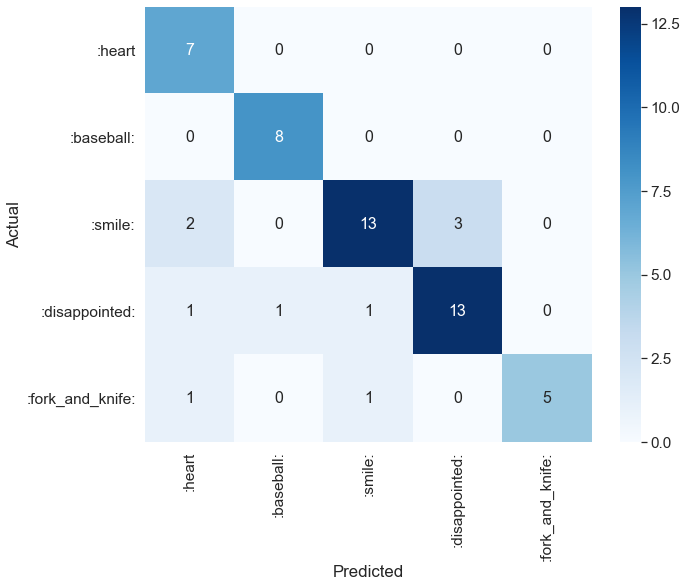

In [15]:
import seaborn as sn

emojis = [":heart", ":baseball:", ":smile:", ":disappointed:", ":fork_and_knife:"]

df_cm = pd.DataFrame(cf_matrix, index=emojis,
                  columns=emojis)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}) # font size

In [16]:
hist = pd.DataFrame(history.history)
hist

,loss,accuracy
0,1.588171,0.242424
1,1.518078,0.416667
2,1.499488,0.340909
3,1.469224,0.333333
4,1.438582,0.409091
5,1.430103,0.492424
6,1.376921,0.500000
7,1.338782,0.484848
8,1.246129,0.507576
9,1.161112,0.522727


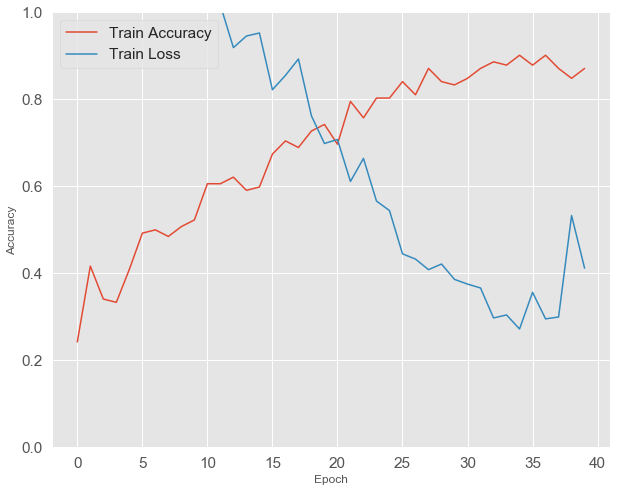

In [17]:
hist['epoch'] = history.epoch

plt.style.use("ggplot")
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
plt.ylim([0,1])
plt.legend()
plt.savefig(cfg.plot_path)

In [19]:
model.save(cfg.model_path)